In [1]:
from utils.videoProcessingFunctions import *
from utils.poseFunctions import *

import matplotlib.pyplot as plt

BaseOptions = mp.tasks.BaseOptions
PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

In [2]:
# model_path = "assets/pose_landmarker_heavy.task"
model_path = "assets/pose_landmarker_lite.task"
video_path = "media/realspeed/Jab-12seconds.mp4"
# video_path = "media/realspeed/hook.mp4"
options = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=model_path),
    running_mode=VisionRunningMode.VIDEO,
    output_segmentation_masks=True,
)
pose_landmarker_results = get_landmarker_results_from_video(
    video_path, options, end_time_ms=25 * 1e3
)

fps=29.99705455278293


c:\Users\adware\Desktop\boxing_dynamics\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Can't read frame. Skipping...


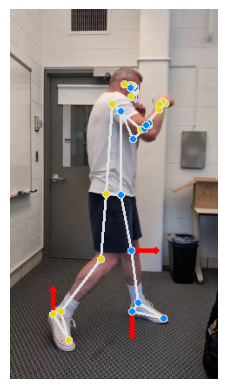

In [3]:
frame_idx = 155
landmarkers = pose_landmarker_results[frame_idx]["landmarker_results"]
original_frame_bgr = pose_landmarker_results[frame_idx][
    "original_frame"
].copy()
height, width, _ = original_frame_bgr.shape
force_x_img, force_y_img = (
    int(landmarkers.pose_landmarks[0][25].x * width),
    int(landmarkers.pose_landmarks[0][25].y * height),
)
cv2.arrowedLine(
    original_frame_bgr,
    pt1=(force_x_img, force_y_img),
    pt2=(force_x_img + 30, force_y_img),
    color=(0, 0, 255),
    thickness=4,
)
force_x_img, force_y_img = (
    int(landmarkers.pose_landmarks[0][30].x * width),
    int(landmarkers.pose_landmarks[0][30].y * height),
)
cv2.arrowedLine(
    original_frame_bgr,
    pt1=(force_x_img, force_y_img),
    pt2=(force_x_img, force_y_img - 30),
    color=(0, 0, 255),
    thickness=4,
)

force_x_img, force_y_img = (
    int(landmarkers.pose_landmarks[0][29].x * width),
    int(landmarkers.pose_landmarks[0][29].y * height),
)
cv2.arrowedLine(
    original_frame_bgr,
    pt1=(force_x_img, force_y_img),
    pt2=(force_x_img, force_y_img + 30),
    color=(0, 0, 255),
    thickness=4,
)

original_frame_rgb = cv2.cvtColor(
    original_frame_bgr, cv2.COLOR_BGR2RGB
)
annotated_frame = draw_landmarks_on_image(
    original_frame_rgb,
    landmarkers,
)
plt.close("all")
plt.imshow(annotated_frame)
plt.axis("off")  # hide axes
plt.show()

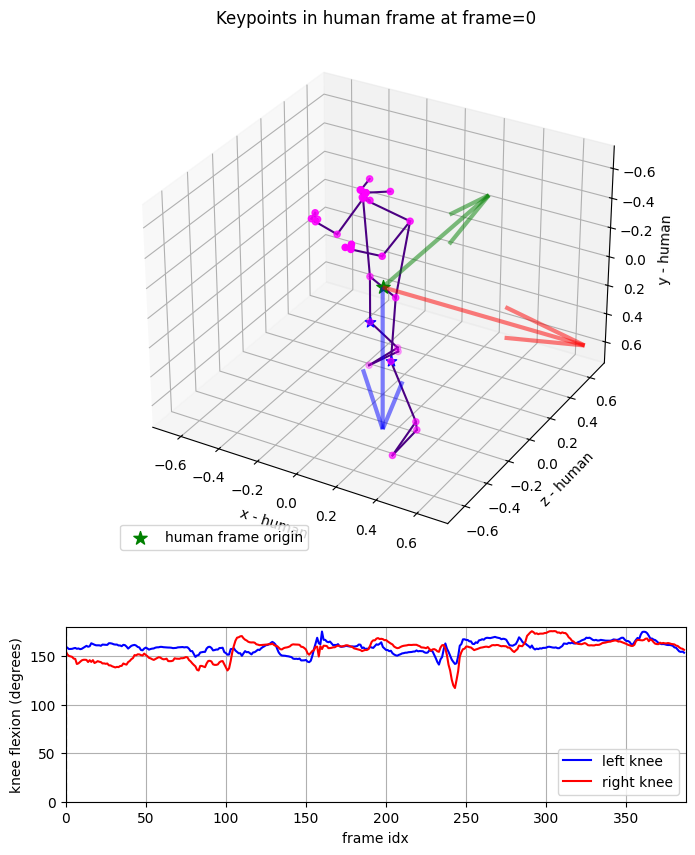

In [ ]:
from matplotlib.animation import FuncAnimation

import matplotlib.gridspec as gridspec

plt.close("all")
fig = plt.figure(figsize=(8, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

ax1 = fig.add_subplot(gs[0], projection="3d")
ax2 = fig.add_subplot(gs[1])

num_frames = len(pose_landmarker_results)

ax2.set(
    xlim=(0, num_frames),
    ylim=(0, 180),
    xlabel="frame idx",
    ylabel="knee flexion (degrees)",
)

left_angles = []
right_angles = []
for result in pose_landmarker_results[:num_frames]:
    left_knee_angle, right_knee_angle = (
        calculate_left_right_knee_flexion(result)
    )
    left_angles.append(left_knee_angle)
    right_angles.append(right_knee_angle)

ax2.plot(range(num_frames), left_angles, color="b", label="left knee")
ax2.plot(
    range(num_frames), right_angles, color="r", label="right knee"
)
ax2.grid(True)
ax2.legend(loc="lower right")

cursor_line = ax2.axvline(0, color="k", linestyle="--")

# def update(frame_idx):
#     ax1.cla()
#     draw_3d_pose_human_frame(pose_landmarker_results[frame_idx], ax1)
#     ax1.set_title(f"Keypoints in human frame at frame={frame_idx}")
#     cursor_line.set_xdata([frame_idx])

# anim = FuncAnimation(
#     fig,
#     update,
#     frames=num_frames,
#     interval=50,
# )

anim.save("pose_animation_knee.gif", writer="pillow", fps=15)
# anim.save("pose_animation.mp4", writer="ffmpeg", fps=15)


c:\Users\adware\Desktop\boxing_dynamics\.venv\Lib\site-packages\matplotlib\animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


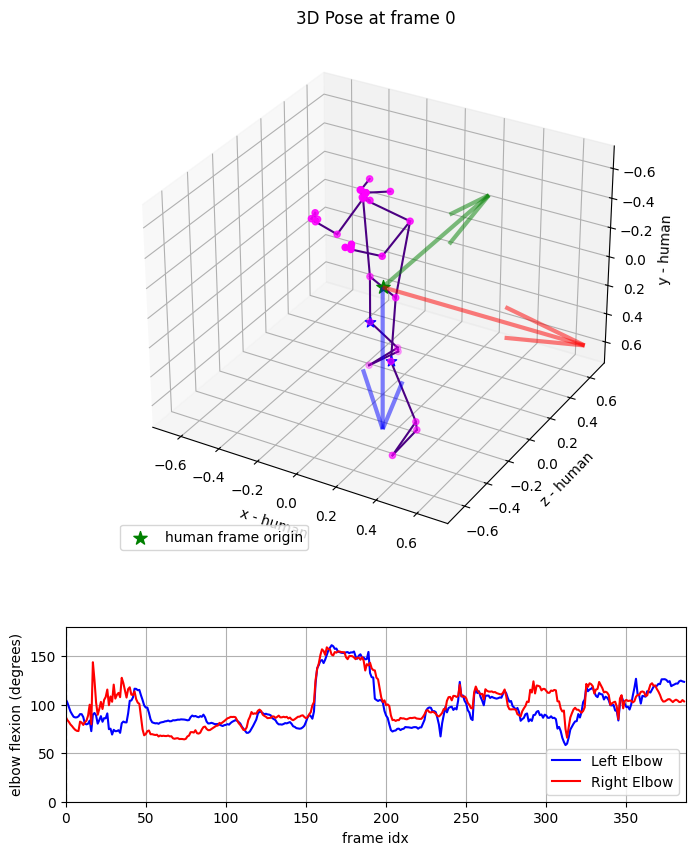

In [6]:
from matplotlib.animation import FuncAnimation
import matplotlib.gridspec as gridspec

# Close previous figures
plt.close("all")

# Create figure with 2 rows: top=3D pose, bottom=elbow angles
fig = plt.figure(figsize=(8, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

ax1 = fig.add_subplot(gs[0], projection="3d")
ax2 = fig.add_subplot(gs[1])

num_frames = len(pose_landmarker_results)

# Ax2 setup (elbow flexion angle plot)
ax2.set(
    xlim=(0, num_frames),
    ylim=(0, 180),
    xlabel="frame idx",
    ylabel="elbow flexion (degrees)",
)

# Precompute left and right elbow angles
left_elbow_angles = []
right_elbow_angles = []
for result in pose_landmarker_results[:num_frames]:
    left_angle, right_angle = calculate_left_right_elbow_flexion(result)
    left_elbow_angles.append(left_angle)
    right_elbow_angles.append(right_angle)

# Plot static elbow angle curves
ax2.plot(range(num_frames), left_elbow_angles, color="b", label="Left Elbow")
ax2.plot(range(num_frames), right_elbow_angles, color="r", label="Right Elbow")
ax2.grid(True)
ax2.legend(loc="lower right")

# Cursor line to move with animation
cursor_line = ax2.axvline(0, color="k", linestyle="--")

# Update function for each frame
def update(frame_idx):
    ax1.cla()
    draw_3d_pose_human_frame(pose_landmarker_results[frame_idx], ax1)
    ax1.set_title(f"3D Pose at frame {frame_idx}")
    cursor_line.set_xdata([frame_idx])

# Animate
anim = FuncAnimation(
    fig,
    update,
    frames=num_frames,
    interval=50,  # ms per frame
)

# plt.show()
anim.save("pose_animation_elbow.gif", writer="pillow", fps=15)
